In [1]:
## Install necessary packages
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt


In [2]:
# First step in pipeline is perspective transformation for bird's eye view 
def birds_eye(img):
    h,w = img.shape[:2]
    src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
    dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    bird_eye_img = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return bird_eye_img, M, Minv

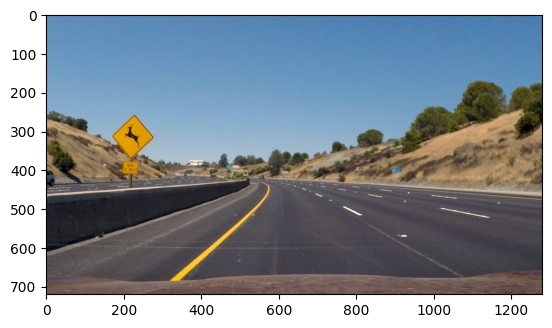

In [3]:
# visualize transformation 
exampleImg = cv2.imread('./test_images/test2.jpg')
left_turn_image = cv2.imread('left_turn.png')
left_turn_image = cv2.cvtColor(left_turn_image, cv2.COLOR_BGR2RGB)

right_turn_image = cv2.imread('right_turn.png')
right_turn_image = cv2.cvtColor(right_turn_image, cv2.COLOR_BGR2RGB)

go_straight_image = cv2.imread('straight.png')
go_straight_image = cv2.cvtColor(go_straight_image, cv2.COLOR_BGR2RGB)


exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
bird_eye_img, _, Minv = birds_eye(exampleImg)
plt.imshow(exampleImg)



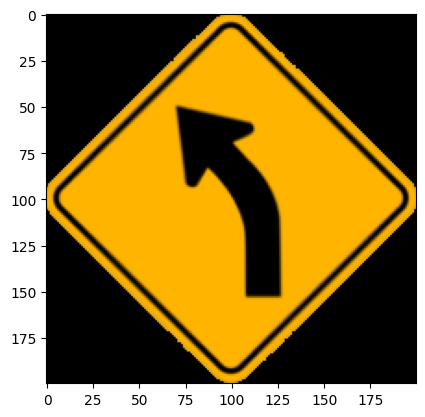

In [4]:
plt.imshow(left_turn_image)


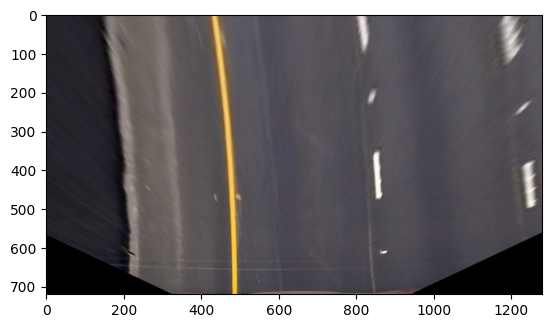

In [5]:
plt.imshow(bird_eye_img)


In [6]:
## Second step is applying binary thresholding to the image to extract only yellow and white lines

def bin_thsh(img, thresh1=(220,255), thresh2=(190,255)):
    #first apply the hls_l threshold 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l * (255/np.max(hls_l))
    binary_output_l = np.zeros_like(hls_l)
    binary_output_l[(hls_l>thresh1[0]) & (hls_l <= thresh1[1])] = 1

    # then apply the Lab B Channel threshold
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))

    binary_output_b = np.zeros_like(lab_b)
    binary_output_b[(lab_b > thresh2[0]) & (lab_b <= thresh2[1])] = 1

    # combine the two
    binary_output = np.zeros_like(binary_output_b)
    binary_output[(binary_output_l == 1) | (binary_output_b == 1)] =1

    return binary_output



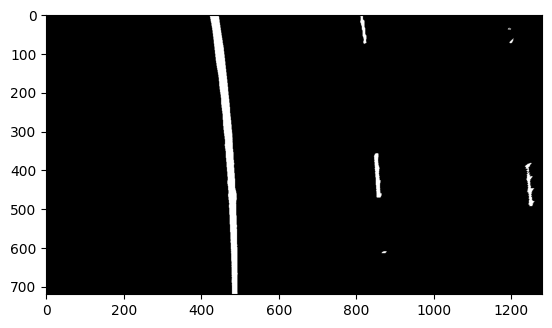

In [7]:
binary_threshold_img = bin_thsh(bird_eye_img)
plt.imshow(binary_threshold_img, cmap='gray')

In [8]:
# Sliding Window Fit

def sliding_window_polyfit(img):

    # plot a histogram to find starting point search for the two lanes
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = int(histogram.shape[0]//2)
    quarter_point = int(midpoint//2)

    # left lane base and right lane base
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:midpoint+quarter_point]) + midpoint

    nwindows = 40
    window_height = int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 80
    minpix = 40

    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data


447
480
Turn Left


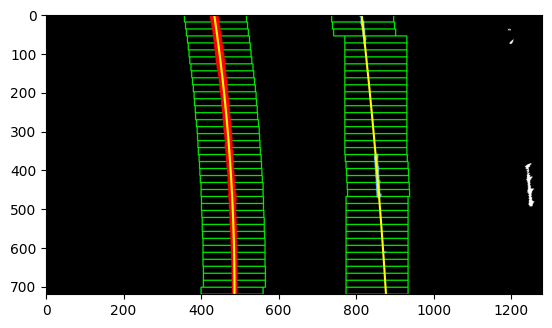

In [9]:
## Visualizing Sliding Window
exampleImg = cv2.imread('./test_images/test2.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin = binary_threshold_img
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)
h = exampleImg.shape[0]

left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

print(nonzerox[left_lane_inds][-1]) # use to display go ahead, turn left, turn right
print(nonzerox[left_lane_inds][0]) #


#print(left_lane_inds[0])


def turn_dir(img_bin, left_lane_inds):
    nonzero = img_bin.nonzero()
    nonzerox = np.array(nonzero[1])
    diff = nonzerox[left_lane_inds][-1] - nonzerox[left_lane_inds][0]; 
    
    if(diff > 30):
        return "Turn Right"
    elif (diff < -30):
        return "Turn Left"
    else: 
        return "Go Straight"


print(turn_dir(binary_threshold_img, left_lane_inds))


(720.0, 0.0)

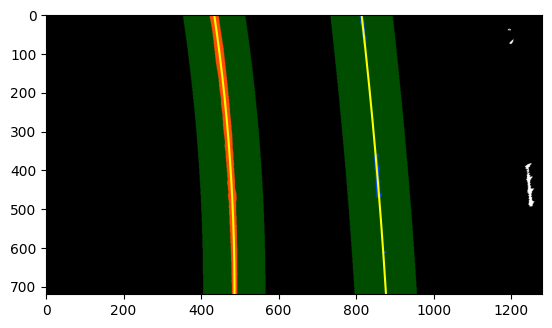

In [10]:
exampleImg2 = cv2.imread('./test_images/test5.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin = binary_threshold_img
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2, _ = sliding_window_polyfit(exampleImg2_bin)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [11]:
# center of lane determination

def calc_center_dist(bin_img, l_fit, r_fit):
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    h = bin_img.shape[0]

    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_dist


In [12]:
d_center = calc_center_dist(binary_threshold_img, left_fit, right_fit)
print(d_center)

-0.40773743586426553


In [13]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (50,150, 255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

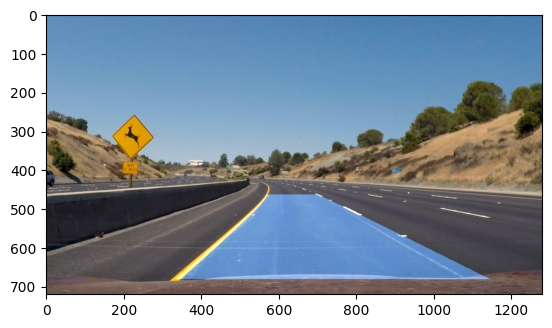

In [14]:
exampleImg_out1 = draw_lane(exampleImg, binary_threshold_img, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)

In [15]:
def draw_data(original_img, center_dist, turn_dir):
    ## calculate grade 
    if(abs(center_dist) < 0.3):
        grade = "A"
    elif (abs(center_dist) < 0.6):
        grade = "B"
    elif (abs(center_dist) < 0.8):
        grade = "C"
    elif (abs(center_dist) < 1.2):
        grade = "D"
    else: 
        grade = "F"
    
    
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Distance from Center of Lane: ' + '{:04.2f}'.format(abs(center_dist) ) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (255,255,100), 2, cv2.LINE_AA)
    text = 'Lane Grade: {}'.format(grade)
    cv2.putText(new_img, text, (40,120), font, 1.5, (255,255,100), 2, cv2.LINE_AA)
    text = '{}'.format(turn_dir)
    cv2.putText(new_img, text, (40,170), font, 1.5, (255,255,100), 2, cv2.LINE_AA)
    
    if(turn_dir ==  "Turn Left"):
        dir_img = left_turn_image
    elif turn_dir == "Turn Right":
        dir_img = right_turn_image
    else:
        dir_img = go_straight_image

    nonzero = dir_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    new_img[nonzeroy, nonzerox+1000] = dir_img[nonzeroy, nonzerox, :]

    return new_img


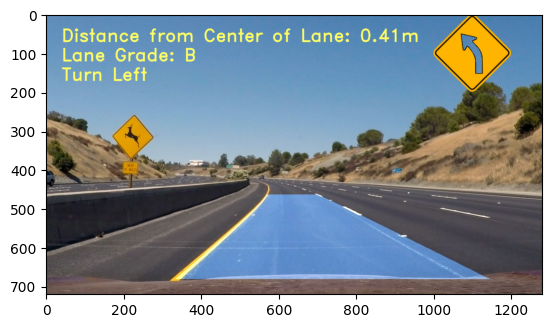

In [16]:
exampleImg_out2 = draw_data(exampleImg_out1, d_center, "Turn Left")
plt.imshow(exampleImg_out2)

In [17]:
# cv2.imshow("result", exampleImg_out2)


In [18]:
video = cv2.VideoCapture("challenge_video.mp4")


In [19]:
video = cv2.VideoCapture("project_video.mp4")
while(video.isOpened()):
    _, frame = video.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # perform image processing
    bird_eye_img, _, Minv = birds_eye(frame)
    binary_threshold_img = bin_thsh(bird_eye_img)

    # sliding window for lane identification
    left_fit, right_fit, left_lane_inds, right_lane_inds, _ = sliding_window_polyfit(binary_threshold_img)

    # driving data
    turn_direction = turn_dir(binary_threshold_img, left_lane_inds)
    d_center = calc_center_dist(binary_threshold_img, left_fit, right_fit)

    # drawing the data
    exampleImg_out1 = draw_lane(frame, binary_threshold_img, left_fit, right_fit, Minv)
    exampleImg_out2 = draw_data(exampleImg_out1, d_center, turn_direction)

    # plt.imshow(exampleImg_out2)
    exampleImg_out2 = cv2.cvtColor(exampleImg_out2, cv2.COLOR_BGR2RGB)
    cv2.imshow("resut", exampleImg_out2)
    cv2.waitKey(100)


    


In [ ]:
# cv2.imshow("resut", exampleImg_out2)
# cv2.waitKey(10)